# GENERADOR DE ALBUMES

# 0. Importación packages y constantes

In [64]:
import os.path
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from PIL import Image

# Packages propios
from utils.objectdetection import ObjectDetectionHelper
from utils.graphdbmanipulation import ImagesGraphDB
from utils.imagesmanipulation import ImageHelper
from utils.analytics import AnalyticsHelper

In [13]:
# GRAFO DE DETECCIÓN DE OBJETOS COCO y PERSONALIZADOS
PATH_COCO_AND_CUSTOM_OBJECTS_GML_FILE = './outputs/graph_databases/graph_OBJECTS_CANDLES.gml'
PATH_RIVERS_LAKES_GML_FILE = './outputs/graph_databases/graph_RIVERS_LAKES.gml'
PATH_GEO_TIME_GML_FILE = './outputs/graph_databases/graph_GEO_TIME.gml'
PATH_FACE_RECOG_GML_FILE = './outputs/graph_databases/graph_FACE_RECOG.gml'
MIN_IMAGES_TRIP = 20

# 1. CARGA DE GRAFOS EXTRAÍDOS Y DE ETIQUETAS MANUALES

In [14]:
imagesGraphDB = ImagesGraphDB()
imagesGraphDB.load_graph_from_gml_file(PATH_COCO_AND_CUSTOM_OBJECTS_GML_FILE)
imagesGraphDB.load_graph_from_gml_file(PATH_RIVERS_LAKES_GML_FILE)
imagesGraphDB.load_graph_from_gml_file(PATH_GEO_TIME_GML_FILE)
imagesGraphDB.load_graph_from_gml_file(PATH_FACE_RECOG_GML_FILE)

In [15]:
df_images_labeled_manually = pd.read_excel('./resources/manual_labels/etiquetado_manual_imagenes.xlsx',skiprows=1)
df_images_labeled_manually.head(10)

,Image,Viaje,comida,Cena,Cumpleaños,Retrato,Maria,Biel,Yo,Piscina,...,Tenedor,Cuchillo,Cuchara,bowl,pastel,silla,Mesa,Plato,Vaso,Llama vela
0,20210724_100218.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,1,1,0,0
1,20210724_104730.jpg,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,20210724_104736.jpg,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,20210724_104739.jpg,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,20210724_104743.jpg,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
5,20210724_104757.jpg,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
6,20210724_200143.jpg,0,0,0,0,1,1,0,1,0,...,0,0,0,0,0,1,1,0,0,0
7,20210724_200145.jpg,0,0,0,0,1,1,0,1,0,...,0,0,0,0,0,1,1,0,0,0
8,20210724_200231_02.jpg,0,0,0,0,1,1,0,1,0,...,0,0,0,0,0,1,1,0,0,0
9,20210724_200231_03.jpg,0,0,0,0,1,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0


# 2. EXTRACCIÓN DE EVENTOS

## 2.1. COMIDAS Y CENAS

### 2.1.1. Obtención de las imagenes predecidas de comidas y cenas

El algoritmo utilizado se basaria en los siguientes pasos:
- encontrar imagenes que contengan mesas, botellas y vasos de vino
- obtener el dia en que fueron tomadas esas fotos y en que franja horaria (madrugada, mañana, tarde o noche)
- obtener el resto de fotos de esos dias y franjas horarias, al ser muy probables que pertenezcan al mismo evento comida o cena.

In [44]:
# Creo función para detectar intersecciones en listas
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [53]:
# Se obtiene las imágenes del grafo que se relacionan con los nodos "dining table","bottle" y "wine glass"
object_classes_to_filter = ['dining table'] # Se cogerán las imágenes con pasteles, personas y velas encendidas
dining_table_images_list = imagesGraphDB.get_images_containing_list_object_types(['dining table'])
bottle_images_list = imagesGraphDB.get_images_containing_list_object_types(['bottle'])
wine_glass_list = imagesGraphDB.get_images_containing_list_object_types(['wine glass'])

# Se busca la intersección de los tres conjuntos de imágenes
lunch_dinner_detected_list = intersection(dining_table_images_list,bottle_images_list)
lunch_dinner_detected_list = intersection(lunch_dinner_detected_list,wine_glass_list)


In [54]:
# Se buscan las fechas
df_lunch_dinner_detected_dates = imagesGraphDB.get_neighbours_by_type_of_node_list(lunch_dinner_detected_list,'image_filename','fecha')
# Se obtienen las franjas de los conjuntos de imágenes obtenidos
df_lunch_dinner_detected_franjas = imagesGraphDB.get_neighbours_by_type_of_node_list(lunch_dinner_detected_list,'image_filename','franja')

In [55]:
# Se cruzan los datos de franjas horarias y fechas
df_lunch_dinner_detected = pd.merge(df_lunch_dinner_detected_dates,df_lunch_dinner_detected_franjas,on='image_filename')

In [56]:
# Se separan las imágenes de comidas y cenas detectadas en función de las franjas horarias
df_lunch_detected = df_lunch_dinner_detected[df_lunch_dinner_detected['franja']=='afternoon']
df_supper_detected = df_lunch_dinner_detected[df_lunch_dinner_detected['franja'].isin(['night','early_morning'])]

In [57]:
# Se busca el listado de imagenes en los mismos días y franjas horarias porque se considera probable que pertenezcan al mismo evento de comida o cena

# COMIDAS
df_total_lunch_candidates_images = imagesGraphDB.get_neighbours_by_type_of_node_list(list(set(df_lunch_detected['fecha'].to_list())),'fecha','image_filename')
total_lunch_candidates_images_list = df_total_lunch_candidates_images['image_filename'].to_list()
df_total_lunch_candidates_images_franja = imagesGraphDB.get_neighbours_by_type_of_node_list(total_lunch_candidates_images_list,'image_filename','franja')
df_total_lunch_images = df_total_lunch_candidates_images_franja[df_total_lunch_candidates_images_franja['franja'].isin(['afternoon'])]
df_total_lunch_images = pd.merge(df_total_lunch_images,df_total_lunch_candidates_images,on='image_filename')

#CENAS
df_total_supper_candidates_images = imagesGraphDB.get_neighbours_by_type_of_node_list(list(set(df_supper_detected['fecha'].to_list())),'fecha','image_filename')
total_supper_candidates_images_list = df_total_supper_candidates_images['image_filename'].to_list()
df_total_supper_candidates_images_franja = imagesGraphDB.get_neighbours_by_type_of_node_list(total_supper_candidates_images_list,'image_filename','franja')
df_supper_images_predicted = df_total_supper_candidates_images_franja[df_total_supper_candidates_images_franja['franja'].isin(['night','early_morning'])]
df_supper_images_predicted = pd.merge(df_supper_images_predicted,df_total_supper_candidates_images,on='image_filename')

### 2.1.2. Matrices de confusión

#### Cenas

Se prepara un dataframe con las columnas reales y predecidas de cenas

In [59]:
df_supper_images_predicted['Cena predicted'] = 1
df_images_supper_manual = df_images_labeled_manually[['Image','Cena']].copy()
df_supper_analysis = df_images_labeled_manually.merge(df_supper_images_predicted , how="left", left_on="Image", right_on="image_filename")
# Se informa con valor 0 aquellas imagenes sin detección de rios y lagos
# en lugar de NA
df_supper_analysis['Cena predicted'] = df_supper_analysis['Cena predicted']. fillna(0)

# Se convierte a int la columna ya que se usa como booleano
df_supper_analysis['Cena predicted'] = df_supper_analysis['Cena predicted'].astype('int')

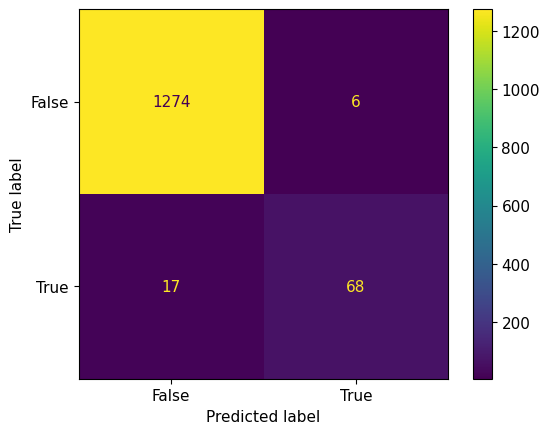

In [62]:
from sklearn import metrics

# Se cargan los resultados de la predicción y el real
images_supper_actual= df_supper_analysis['Cena'].to_numpy()
images_supper_predicted= df_supper_analysis['Cena predicted'].to_numpy()
# Se cargan los datos para generar la matriz de confusión
confusion_matrix = metrics.confusion_matrix(images_supper_actual, images_supper_predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
# Se muestra el gráfico
cm_display.plot()
plt.show()

### 2.1.3. Métricas

#### Cenas

In [65]:
analyticsHelper = AnalyticsHelper()
metrics = analyticsHelper.getBinaryClassificationConfusionMatrixMetrics(confusion_matrix)
metrics

{'recall': 0.8,
 'precision': 0.918918918918919,
 'accuracy': 0.9831501831501831,
 'specificity': 0.9953125,
 'f1_score': 0.8553459119496855}

## 2.2. CUMPLEAÑOS

In [18]:
# Se obtiene las imágenes del grafo que se relacionan con los nodos "person", "cake" y "candle_light"
object_classes_to_filter = ['person','cake','candle_light'] # Se cogerán las imágenes con pasteles, personas y velas encendidas
birhtday_images_list = imagesGraphDB.get_images_containing_list_object_types(object_classes_to_filter)

# Se obtienen las fechas de las imagenes de cumpleaños
df_birthday_dates = imagesGraphDB.get_neighbours_by_type_of_node_list(birhtday_images_list,'image_filename','fecha')

# Se busca el listado de imagenes de esos dias
df_birthday_images = imagesGraphDB.get_neighbours_by_type_of_node_list(list(set(df_birthday_dates['fecha'].to_list())),'fecha','image_filename')


Se obtiene el número de imágenes por fecha de celebración de cumpleaños

In [19]:
df_birthday_albumes_proposal = df_birthday_images.groupby(['fecha']).aggregate({'image_filename':'count'})
df_birthday_albumes_proposal.rename(columns = {'image_filename':'numero_imagenes'},inplace=True)
df_birthday_albumes_proposal

,numero_imagenes
fecha,
2021_8_26,31
2021_9_19,5
2021_9_6,12
2022_4_18,4
2022_9_18,11


Tres de los cinco álbumes de cumpleaños propuestos lo serían realmente. Uno de ellos se trata de una celebración con pastel y el otro es realmente una cena en que se confunde un plato de carne con un pastel. Hay una foto de cumpleaños que no se detecta, pero tres de los cuatro cumpleaños de los que se disponen de imagenes son detectados y propuesto un album.

# 3. ESCENAS

## 3.1. LAGOS Y RIOS

In [12]:
# TODO

# 4. VIAJES

## 4.1. Agrupados por provincia y año

Se obtiene la información del grafo de imagenes a más de 100km de la residencia habitual y se complementan con información de la provincia, comunidad autonoma y año.

In [10]:
# Primero se obtienen las imagnes obtenidas en ubicaciones a mas de 100km
images = imagesGraphDB.get_images_distance_gt(200)
# Se obtienen las provincias de las imagenes a mas de 200km
df_province = imagesGraphDB.get_neighbours_by_type_of_node_list(images,'image_filename','provincia')
# Se obtiene el año en que fue tomada cada imagen
df_year = imagesGraphDB.get_neighbours_by_type_of_node_list(images,'image_filename','anyo')

Se junta la información en un solo dataframe

In [11]:
df_images_albumes = pd.merge(df_province,df_year,on='image_filename')
df_images_albumes

,image_filename,provincia,anyo
0,20210826_195318.jpg,Soria,2021
1,20210826_195324.jpg,Soria,2021
2,20210826_195328.jpg,Soria,2021
3,20210826_200606.jpg,Soria,2021
4,20210826_200610.jpg,Soria,2021
...,...,...,...
298,20210831_122453.jpg,Burgos,2021
299,20210831_123216.jpg,Burgos,2021
300,20210831_130745.jpg,Burgos,2021
301,20210831_130851.jpg,Burgos,2021


In [13]:
df_images_albumes['viajes'] = df_images_albumes['provincia'] +'_'+ df_images_albumes['anyo']
df_trip_albumes_proposal = df_images_albumes.groupby(['viajes']).aggregate({'image_filename':'count'})
df_trip_albumes_proposal.rename(columns = {'image_filename':'numero_imagenes'},inplace=True)
df_trip_albumes = df_trip_albumes_proposal[df_trip_albumes_proposal['numero_imagenes']>MIN_IMAGES_TRIP]

In [14]:
df_trip_albumes

,numero_imagenes
viajes,
Burgos_2021,65
Cantabria_2021,84
Soria_2021,152


Mediante esta técnica se han detectado tres viajes que forman parte de las vacaciones de verano realizadas en el año 2021 y de las cuales se disponían de coordenadas de latitud y longitud.